# Comparison of HulC and Wald intervals:
## Multiple Linear Regression

In [5]:
### HulC.R contains all the functions to the HulC procedure.
source("HulC.R")

### loading necessary packages for computation and plotting.
library("sandwich")
library("ggplot2")
library("cowplot")
library("gridExtra")
library("repr")
library("boot")

In the following, we will compare the HulC and Wald confidence intervals for the slope of one of the covariates from a multiple linear regression. We have observations $(X_i, Y_i), 1\le i\le n$ from the model
$Y_i = |\theta_0^{\top}X_i| + \xi_i$, where $\xi_i\sim N(0, 1)$ and $X_i\in\mathbb{R}^6$ is generated according to the following law: $$(X_{i,1}, X_{i,2}) \sim \text{Uniform} [-1,1]^2,$$ $$ X_{i,3}:=0.2 X_{i,1}+ 0.2 (X_{i,2}+2)^2+0.2 Z_{i,1},$$ $$X_{i,4}:=0.1+ 0.1(X_{i,1}+X_{i,2})+0.3(X_{i,1}+1.5)^2+  0.2 Z_{i,2},$$ $$X_{i,5} \sim \text{Ber}(\exp(X_{i,1})/\{1+\exp(X_{i,1})\}),$$ and  $$ X_{i,6} \sim \text{Ber}(\exp(X_{i,2})/\{1+\exp(X_{i,2})\}).$$ Here $(Z_{i,1}, Z_{i,2})\sim\text{Uniform} [-1,1]^2$ is independent of $(X_{i,1},X_{i,2})$ and $\theta_0 = (1.3, -1.3, 1, -0.5, -0.5, -0.5)/\sqrt{5.13}$. This is a misspecified linear regression model. Our estimator and target are defined as
$$
(\widehat{\alpha},\widehat{\beta},\widehat{\gamma}) := \underset{\alpha,\beta,\gamma}{\text{argmin}}\,\frac{1}{n}\sum_{i=1}^n (Y_i - \alpha - \beta X_{i,1}^2 - \gamma^{\top}X_{i,-1})^2,\quad\mbox{and}\quad (\alpha^*, \beta^*, \gamma^*) := \underset{\alpha,\beta,\gamma}{\text{argmin}}\,\mathbb{E}[(Y - \alpha - \beta X_1 - \gamma^{\top}X_{-1})^2],
$$
where $X_{i,-1}$ and $X_{-1}$ represent the last 5 coordinates of $X_{i}$ and $X$ respectively. With Monte Carlo approximation of $\mathbb{E}[\cdot]$, we found that $\beta^* = -0.137323$. This Monte-Carlo computation is done in the following code.

In [3]:
# This is computed using a Monte Carlo simulation below with 1e08 samples from the model. 
# nsamp <- 1e08
# x1 <- runif(nsamp,-1,1)
# x2 <- runif(nsamp,-1,1)
# e1 <- runif(nsamp,-1,1)
# e2 <- runif(nsamp,-1,1)
# x3 <- 0.2*x1 + 0.2*(x2 + 2)^2 + 0.2*e1
# x4 <- 0.1 + 0.1*(x1 + x2) + 0.3*(x1 + 1.5)^2 + 0.2*e2
# x5 <- rbinom(nsamp,1,exp(x1)/{1 + exp(x1)})
# x6 <- rbinom(nsamp,1,exp(x2)/{1 + exp(x2)})
# x <- cbind(x1,x2,x3,x4,x5,x6)
# beta0 <- c(1.3, -1.3, 1, -0.5, 0.5, -0.5)/sqrt(5.13)
# m0 <- function(t){
#   return(abs(t))
# }
# y <- m0(x%*%beta0) + rnorm(nsamp)
# proj_beta <- unname(lm(y ~ x)$coefficients[2])
proj_beta <- -0.137323

Our aim is to construct a confidence interval for $\beta^*$. Note that $\widehat{\beta}$ is a consistent estimator for $\beta^*$. The classical Wald interval with sandwich covariance matrix is an asymptotically valid confidence interval for $\beta^*$. Because the limiting distribution is Gaussian, the asymptotic median bias of $\widehat{\beta}$ is zero and hence HulC can be applied with $\Delta = 0$. The following function (`foo`) generates data from the model above and computes the HulC as well as Wald confidence interval at $95\%$ level.

In [4]:
foo <- function(nsamp, name, alpha = 0.05){
  x1 <- runif(nsamp,-1,1)
  x2 <- runif(nsamp,-1,1)
  e1 <- runif(nsamp,-1,1)
  e2 <- runif(nsamp,-1,1)
  x3 <- 0.2*x1 + 0.2*(x2 + 2)^2 + 0.2*e1
  x4 <- 0.1 + 0.1*(x1 + x2) + 0.3*(x1 + 1.5)^2 + 0.2*e2
  x5 <- rbinom(nsamp,1,exp(x1)/{1 + exp(x1)})
  x6 <- rbinom(nsamp,1,exp(x2)/{1 + exp(x2)})
  x <- cbind(x1,x2,x3,x4,x5,x6)
  beta0 <- c(1.3, -1.3, 1, -0.5, 0.5, -0.5)/sqrt(5.13)
  m0 <- function(t){
    return(abs(t))
  }
  y <- m0(x%*%beta0) + rnorm(nsamp)
    data <- cbind(y, x)
    if(name == "HulC"){
        estimate <- function(dat_tmp){
            fit <- lm(dat_tmp[,1] ~ dat_tmp[,-1])
            return(unname(fit$coeff)[2])
        }
        tmp <- as.vector(HulC(data, estimate, alpha = alpha, Delta = 0, dim = 1)$CI)
    }
    if(name == "Wald"){
        mod <- lm(data[,1] ~ data[,-1])
        est <- unname(mod$coeff[2])
        sd_est <- sqrt(vcovHC(mod, type = "HC")[2,2])
        tmp <- est + c(-1, 1)*qnorm(1-alpha/2)*sd_est
    }
    return(tmp)
}

## HulC confidence interval
print("HulC confidence interval:")
foo(100, "HulC", alpha = 0.05)

## Wald confidence interval
print("Wald confidence interval:")
foo(100, "Wald", alpha = 0.05)

[1] "HulC confidence interval:"


[1] -6.433510  9.264859

[1] "Wald confidence interval:"


[1] -0.9893345  2.3498843

## Simulation
The following code computes the HulC and Wald confidence intervals for 20 different sample sizes from 20 to 500. For reproducibility, seed is set at 2021. For each sample size, we perform 1000 replications to compute the width and coverage.

In [5]:
set.seed(2021)
nsamp_seq <- round(seq(20, 500, length = 20))
name_seq <- c("HulC", "Wald")
nrep <- 1000
rep_seq <- 1:nrep
grid <- expand.grid(nsamp_seq, name_seq, rep_seq)
colnames(grid) <- c("nsamp", "name", "rep")
width_mat <- data.frame(value = rep(0, nrow(grid)), nsamp = grid$nsamp, name = grid$name, rep = grid$rep)
cov_mat <- width_mat

for(idx in 1:nrow(grid)){
    #if(idx%%1000 == 0){
    #  print(idx)
    #}
    tmp <- foo(grid[idx,1], grid[idx,2], alpha = 0.05)
    width_mat[idx, 1] <- (tmp[2] - tmp[1])
    true_beta <- proj_beta
    cov_mat[idx, 1] <- (tmp[1] <= true_beta && true_beta <= tmp[2])
}
print("Simulation with 1000 replications done!!")

[1] "Simulation with 1000 replications done!!"


In [6]:
new_width_mat<- width_mat[width_mat$name == "HulC",]
new_width_mat$value <- new_width_mat$value/width_mat[width_mat$name == "Wald","value"]
tmp_width_mat <- new_width_mat[new_width_mat$value <= 7.5,]

nsamp_seq <- round(seq(20, 500, length = 20))
name_seq <- c("HulC", "Wald")
grid_new <- expand.grid(nsamp_seq, name_seq)
colnames(grid_new) <- c("nsamp", "name")
col.cov<- data.frame(cov = rep(0, nrow(grid_new)), nsamp = grid_new$nsamp, name = grid_new$name)
for(idx in 1:nrow(grid_new)){
  temp.width <- cov_mat[cov_mat$nsamp==grid_new[idx,"nsamp"],]
  temp.width2 <- temp.width[temp.width$name==grid_new[idx,"name"],]
  col.cov[idx,1] <- mean(temp.width2$value)
}

# Plotting

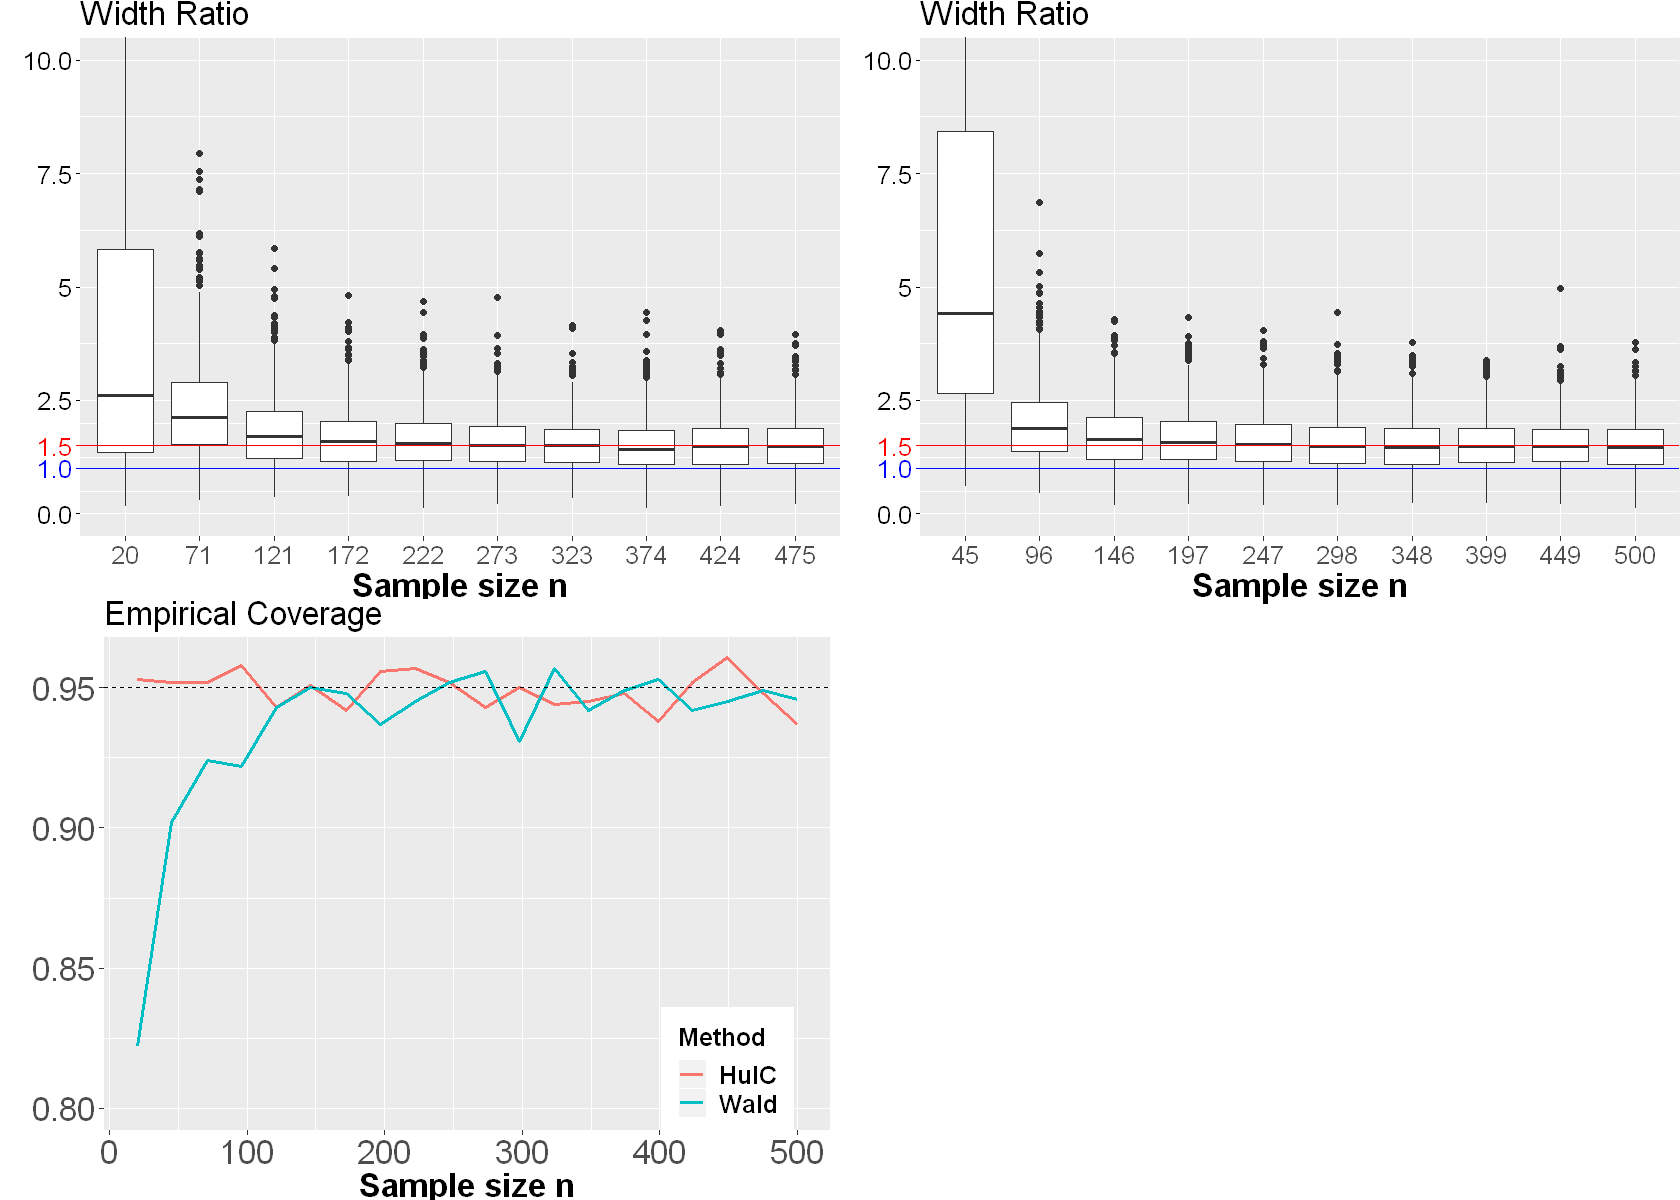

In [7]:
new_width_mat1 <- new_width_mat[new_width_mat$nsamp %in% nsamp_seq[seq(1,20,by=2)],]
new_width_mat2 <- new_width_mat[new_width_mat$nsamp %in% nsamp_seq[seq(2,20,by=2)],]
g1 <- ggplot(data= new_width_mat1, mapping= aes(x=as.factor(nsamp), y =value)) +
  geom_boxplot()+geom_hline(yintercept = 1.5,color="red")+labs(x="Sample size n", title = "Width Ratio", y = "")+theme(
    axis.text.x = element_text(size = 15),
    axis.text.y = element_text(size = 15),
    axis.title=element_text(size=20,face="bold"),
    strip.text = element_text(size=20,face = "bold"),
    plot.margin = unit(c(0, 0, 0, -0.2), "cm"),
    plot.title = element_text(size=20)) + 
  geom_hline(yintercept=1,color="blue") + 
  coord_cartesian(xlim = NULL, ylim = c(0, 10)) +
  scale_y_continuous(breaks=c(0, 1, 1.5, 2.5, 5, 7.5, 10), 
                    labels=c("0.0", "1.0", "1.5", "2.5", "5", "7.5", "10.0")) + 
  theme(axis.text.y = element_text(color = c("black", "blue", "red", "black", "black", "black", "black")),
                                  axis.ticks.y = element_line(color = c("black", "blue", "red", "black", "black", "black", "black"),
                                size = c(.5,0.5,0.5,.5,.5,.5,.5)))
g1p <- ggplot(data= new_width_mat2, mapping= aes(x=as.factor(nsamp), y =value)) +
  geom_boxplot()+geom_hline(yintercept = 1.5,color="red")+labs(x="Sample size n", title = "Width Ratio", y = "")+theme(
    axis.text.x = element_text(size = 15),
    axis.text.y = element_text(size = 15),
    axis.title=element_text(size=20,face="bold"),
    strip.text = element_text(size=20,face = "bold"),
    plot.margin = unit(c(0, 0, 0, -0.2), "cm"),
    plot.title = element_text(size=20)) + 
  geom_hline(yintercept=1,color="blue") + 
  coord_cartesian(xlim = NULL, ylim = c(0, 10)) +
  scale_y_continuous(breaks=c(0, 1, 1.5, 2.5, 5, 7.5, 10), 
                    labels=c("0.0", "1.0", "1.5", "2.5", "5", "7.5", "10.0")) + 
  theme(axis.text.y = element_text(color = c("black", "blue", "red", "black", "black", "black", "black")),
                                  axis.ticks.y = element_line(color = c("black", "blue", "red", "black", "black", "black", "black"),
                                size = c(.5,0.5,0.5,.5,.5,.5,.5)))

g2 <- ggplot(data= col.cov, mapping= aes(x=nsamp, y =cov, col=as.factor(name), group= as.factor(name))) +
  geom_line(size = 1.1) + geom_hline(yintercept = 0.95, linetype = 2) + coord_cartesian(xlim = NULL, ylim = c(0.80, 0.96))+theme(
    legend.position = c(0.95, .25),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.margin = margin(10, 10, 10, 10),
    legend.text=element_text(size=15, face = "bold"),
    legend.title=element_text(size = 15, face = "bold"),
    axis.text.x=element_text(size = 20),
    axis.text.y=element_text(size=20),
    axis.title=element_text(size=20,face="bold"),
    strip.text = element_text(size=20,face = "bold"),
    plot.margin = unit(c(0,0.2,0,0), "cm"),
    plot.title=element_text(size=20),
    axis.text=element_text(size=12)
  )+ scale_color_discrete("Method")+labs(x = "Sample size n", title = "Empirical Coverage", y = "")

options(repr.plot.width=14, repr.plot.height=10)
gridExtra::grid.arrange(g1, g1p, g2, ncol=2)

# Comparison with Bootstrap
In the following code, we compare HulC, Wald, and bootstrap intervals in the multivariate regression setting.

In [7]:
foo <- function(nsamp, name, alpha = 0.05){
  x1 <- runif(nsamp,-1,1)
  x2 <- runif(nsamp,-1,1)
  e1 <- runif(nsamp,-1,1)
  e2 <- runif(nsamp,-1,1)
  x3 <- 0.2*x1 + 0.2*(x2 + 2)^2 + 0.2*e1
  x4 <- 0.1 + 0.1*(x1 + x2) + 0.3*(x1 + 1.5)^2 + 0.2*e2
  x5 <- rbinom(nsamp,1,exp(x1)/{1 + exp(x1)})
  x6 <- rbinom(nsamp,1,exp(x2)/{1 + exp(x2)})
  x <- cbind(x1,x2,x3,x4,x5,x6)
  beta0 <- c(1.3, -1.3, 1, -0.5, 0.5, -0.5)/sqrt(5.13)
  m0 <- function(t){
    return(abs(t))
  }
  y <- m0(x%*%beta0) + rnorm(nsamp)
    data <- cbind(y, x)
    if(name == "HulC"){
        estimate <- function(dat_tmp){
            fit <- lm(dat_tmp[,1] ~ dat_tmp[,-1])
            return(unname(fit$coeff)[2])
        }
        tmp <- as.vector(HulC(data, estimate, alpha = alpha, Delta = 0, dim = 1)$CI)
    }
    if(name == "Wald"){
        mod <- lm(data[,1] ~ data[,-1])
        est <- unname(mod$coeff[2])
        sd_est <- sqrt(vcovHC(mod, type = "HC")[2,2])
        tmp <- est + c(-1, 1)*qnorm(1-alpha/2)*sd_est
    }
    if(name == "basic_boot"){
        boot_coef <- function(DATA, indices){
          dat_xy <- DATA[indices,]
          mod <- lm(dat_xy[,1] ~ dat_xy[,-1])
          m <- unname(mod$coeff[2])
          v <- sqrt(vcovHC(mod, type = "HC")[2,2])
          return(c(m, v))
        }        
        boot_replicates <- boot(data, boot_coef, 500)
        tmp <- boot.ci(boot_replicates, conf = 1 - alpha, type = "basic")$basic[c(4,5)]
    }
    if(name == "perc_boot"){
        boot_coef <- function(DATA, indices){
          dat_xy <- DATA[indices,]
          mod <- lm(dat_xy[,1] ~ dat_xy[,-1])
          m <- unname(mod$coeff[2])
          v <- sqrt(vcovHC(mod, type = "HC")[2,2])
          return(c(m, v))
        }        
        boot_replicates <- boot(data, boot_coef, 500)
        tmp <- boot.ci(boot_replicates, conf = 1 - alpha, type = "perc")$percent[c(4,5)]
    }    
    return(tmp)
}

## HulC confidence interval
print("HulC confidence interval:")
foo(100, "HulC", alpha = 0.05)

## Wald confidence interval
print("Wald confidence interval:")
foo(100, "Wald", alpha = 0.05)

## Bootstrap confidence interval
print("Basic bootstrap confidence interval:")
foo(100, "basic_boot", alpha = 0.05)

## Bootstrap confidence interval
print("Percentile bootstrap confidence interval:")
foo(100, "perc_boot", alpha = 0.05)

[1] "HulC confidence interval:"


[1] -1.8753066 -0.4412469

[1] "Wald confidence interval:"


[1] -2.0499696  0.9503076

[1] "Basic bootstrap confidence interval:"


[1] -1.654513  1.358395

[1] "Percentile bootstrap confidence interval:"


[1] -1.093723  1.580987

In [8]:
set.seed(2021)
nsamp_seq <- round(seq(20, 500, length = 10))
name_seq <- c("HulC", "Wald", "basic_boot", "perc_boot")
nrep <- 200
rep_seq <- 1:nrep
grid <- expand.grid(nsamp_seq, name_seq, rep_seq)
colnames(grid) <- c("nsamp", "name", "rep")
width_mat <- data.frame(value = rep(0, nrow(grid)), nsamp = grid$nsamp, name = grid$name, rep = grid$rep)
cov_mat <- width_mat

for(idx in 1:nrow(grid)){
    #if(idx%%1000 == 0){
    #  print(idx)
    #}
    tmp <- foo(grid[idx,1], grid[idx,2], alpha = 0.05)
    width_mat[idx, 1] <- (tmp[2] - tmp[1])
    true_beta <- proj_beta
    cov_mat[idx, 1] <- (tmp[1] <= true_beta && true_beta <= tmp[2])
}
print("Simulation with 1000 replications done!!")

Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"

[1] "Simulation with 1000 replications done!!"


In [9]:
new_width_mat<- width_mat[width_mat$name == "HulC",]
new_width_mat$value <- new_width_mat$value/width_mat[width_mat$name == "Wald","value"]
tmp_width_mat <- new_width_mat[new_width_mat$value <= 7.5,]

nsamp_seq <- round(seq(20, 500, length = 10))
name_seq <- c("HulC", "Wald", "basic_boot", "perc_boot")
grid_new <- expand.grid(nsamp_seq, name_seq)
colnames(grid_new) <- c("nsamp", "name")
col.cov<- data.frame(cov = rep(0, nrow(grid_new)), nsamp = grid_new$nsamp, name = grid_new$name)
for(idx in 1:nrow(grid_new)){
  temp.width <- cov_mat[cov_mat$nsamp==grid_new[idx,"nsamp"],]
  temp.width2 <- temp.width[temp.width$name==grid_new[idx,"name"],]
  col.cov[idx,1] <- mean(temp.width2$value)
}

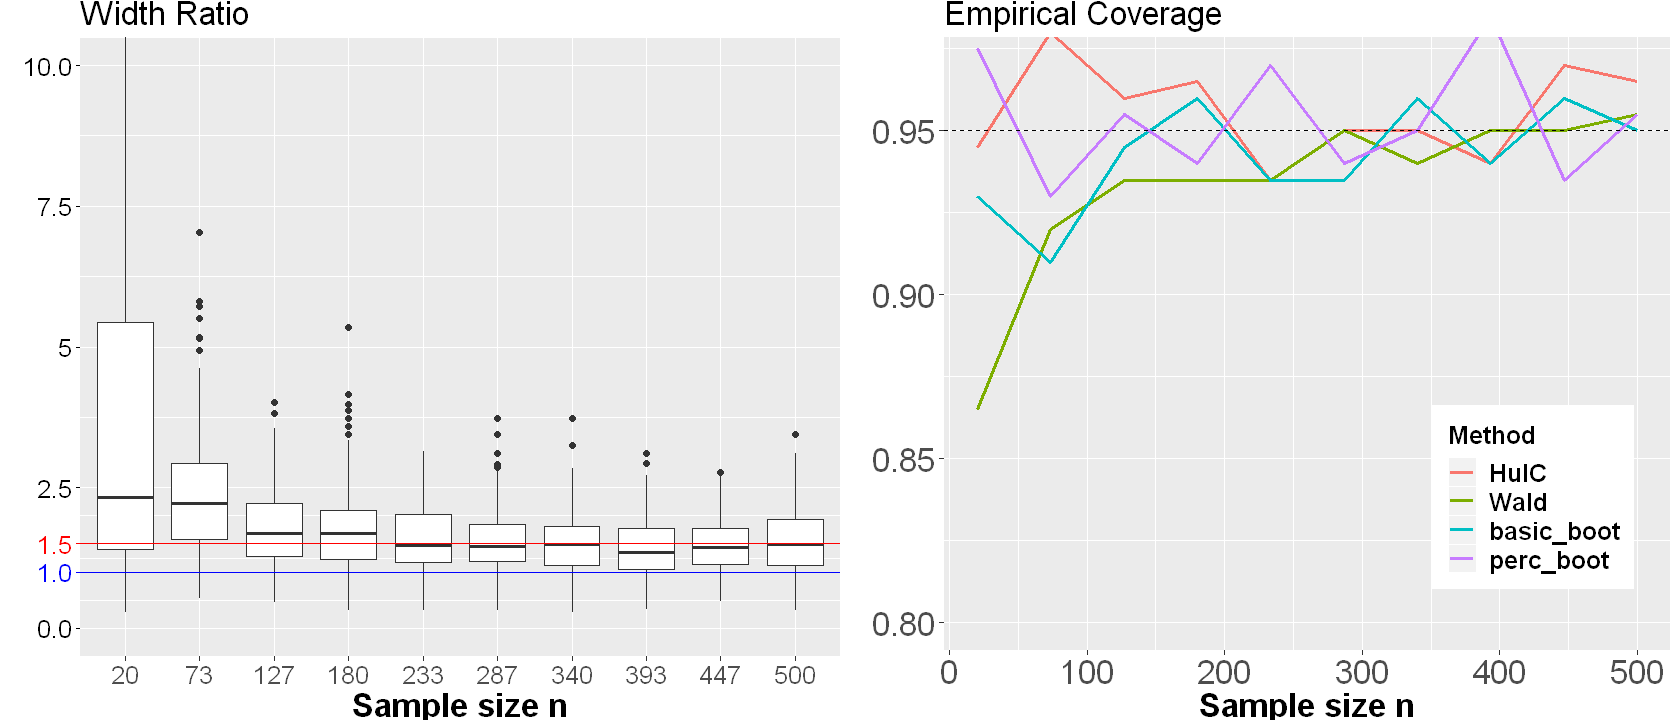

In [15]:
new_width_mat1 <- new_width_mat[new_width_mat$nsamp %in% nsamp_seq[seq(1,10,by=1)],]
# new_width_mat2 <- new_width_mat[new_width_mat$nsamp %in% nsamp_seq[seq(2,10,by=1)],]
g1 <- ggplot(data= new_width_mat1, mapping= aes(x=as.factor(nsamp), y =value)) +
  geom_boxplot()+geom_hline(yintercept = 1.5,color="red")+labs(x="Sample size n", title = "Width Ratio", y = "")+theme(
    axis.text.x = element_text(size = 15),
    axis.text.y = element_text(size = 15),
    axis.title=element_text(size=20,face="bold"),
    strip.text = element_text(size=20,face = "bold"),
    plot.margin = unit(c(0, 0, 0, -0.2), "cm"),
    plot.title = element_text(size=20)) + 
  geom_hline(yintercept=1,color="blue") + 
  coord_cartesian(xlim = NULL, ylim = c(0, 10)) +
  scale_y_continuous(breaks=c(0, 1, 1.5, 2.5, 5, 7.5, 10), 
                    labels=c("0.0", "1.0", "1.5", "2.5", "5", "7.5", "10.0")) + 
  theme(axis.text.y = element_text(color = c("black", "blue", "red", "black", "black", "black", "black")),
                                  axis.ticks.y = element_line(color = c("black", "blue", "red", "black", "black", "black", "black"),
                                size = c(.5,0.5,0.5,.5,.5,.5,.5)))
# g1p <- ggplot(data= new_width_mat2, mapping= aes(x=as.factor(nsamp), y =value)) +
#   geom_boxplot()+geom_hline(yintercept = 1.5,color="red")+labs(x="Sample size n", title = "Width Ratio", y = "")+theme(
#     axis.text.x = element_text(size = 15),
#     axis.text.y = element_text(size = 15),
#     axis.title=element_text(size=20,face="bold"),
#     strip.text = element_text(size=20,face = "bold"),
#     plot.margin = unit(c(0, 0, 0, -0.2), "cm"),
#     plot.title = element_text(size=20)) + 
#   geom_hline(yintercept=1,color="blue") + 
#   coord_cartesian(xlim = NULL, ylim = c(0, 10)) +
#   scale_y_continuous(breaks=c(0, 1, 1.5, 2.5, 5, 7.5, 10), 
#                     labels=c("0.0", "1.0", "1.5", "2.5", "5", "7.5", "10.0")) + 
#   theme(axis.text.y = element_text(color = c("black", "blue", "red", "black", "black", "black", "black")),
#                                   axis.ticks.y = element_line(color = c("black", "blue", "red", "black", "black", "black", "black"),
#                                 size = c(.5,0.5,0.5,.5,.5,.5,.5)))

g2 <- ggplot(data= col.cov, mapping= aes(x=nsamp, y =cov, col=as.factor(name), group= as.factor(name))) +
  geom_line(size = 1.1) + geom_hline(yintercept = 0.95, linetype = 2) + coord_cartesian(xlim = NULL, ylim = c(0.80, 0.97))+theme(
    legend.position = c(0.95, .4),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.margin = margin(10, 10, 10, 10),
    legend.text=element_text(size=15, face = "bold"),
    legend.title=element_text(size = 15, face = "bold"),
    axis.text.x=element_text(size = 20),
    axis.text.y=element_text(size=20),
    axis.title=element_text(size=20,face="bold"),
    strip.text = element_text(size=20,face = "bold"),
    plot.margin = unit(c(0,0.2,0,0), "cm"),
    plot.title=element_text(size=20),
    axis.text=element_text(size=12)
  )+ scale_color_discrete("Method")+labs(x = "Sample size n", title = "Empirical Coverage", y = "")

options(repr.plot.width=14, repr.plot.height=6)
# gridExtra::grid.arrange(g1, g1p, g2, ncol=2)
gridExtra::grid.arrange(g1, g2, ncol=2)